In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        
        # calculate the in_features
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 1 (features), 40 (sequence length)]
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [3]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../../data/processed_data/{i}_table_train.npy')
        temp_val = np.load(f'../../data/processed_data/{i}_table_val.npy')
        temp_test = np.load(f'../../data/processed_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [6]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [7]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [8]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [9]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 40.40it/s]


Train: Epoch 0: Loss 2.3329973220825195, Accuracy 0.09426652892561983
Eval: Epoch 0: Loss 2.304778814315796, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 41.14it/s]


Train: Epoch 1: Loss 2.323476552963257, Accuracy 0.09553202479338842
Eval: Epoch 1: Loss 2.3039212226867676, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 43.34it/s]


Train: Epoch 2: Loss 2.315913200378418, Accuracy 0.09795971074380165
Eval: Epoch 2: Loss 2.304405689239502, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 42.80it/s]


Train: Epoch 3: Loss 2.3138182163238525, Accuracy 0.09522210743801653
Eval: Epoch 3: Loss 2.3039090633392334, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 4: Loss 2.310173511505127, Accuracy 0.09979338842975206
Eval: Epoch 4: Loss 2.303997039794922, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 5: Loss 2.306950330734253, Accuracy 0.09555785123966942
Eval: Epoch 5: Loss 2.3038582801818848, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 43.24it/s]


Train: Epoch 6: Loss 2.302647113800049, Accuracy 0.11299070247933884
Eval: Epoch 6: Loss 2.3035147190093994, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 44.64it/s]


Train: Epoch 7: Loss 2.310175657272339, Accuracy 0.10082644628099174
Eval: Epoch 7: Loss 2.303711175918579, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 42.54it/s]


Train: Epoch 8: Loss 2.3016276359558105, Accuracy 0.1147210743801653
Eval: Epoch 8: Loss 2.3038132190704346, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 42.64it/s]


Train: Epoch 9: Loss 2.305508613586426, Accuracy 0.0993801652892562
Eval: Epoch 9: Loss 2.3036577701568604, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 43.44it/s]


Train: Epoch 10: Loss 2.3033604621887207, Accuracy 0.11200929752066115
Eval: Epoch 10: Loss 2.3039121627807617, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 11: Loss 2.299744129180908, Accuracy 0.1165547520661157
Eval: Epoch 11: Loss 2.3032703399658203, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 43.44it/s]


Train: Epoch 12: Loss 2.3035192489624023, Accuracy 0.10643078512396693
Eval: Epoch 12: Loss 2.3039064407348633, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 13: Loss 2.3056135177612305, Accuracy 0.10736053719008265
Eval: Epoch 13: Loss 2.303741216659546, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 43.20it/s]


Train: Epoch 14: Loss 2.303107976913452, Accuracy 0.11185433884297522
Eval: Epoch 14: Loss 2.3036229610443115, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 43.34it/s]


Train: Epoch 15: Loss 2.302896022796631, Accuracy 0.11221590909090909
Eval: Epoch 15: Loss 2.3032913208007812, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 16: Loss 2.302347183227539, Accuracy 0.1071797520661157
Eval: Epoch 16: Loss 2.303076982498169, Accuracy 0.1099609375


100%|██████████| 55/55 [00:01<00:00, 45.27it/s]


Train: Epoch 17: Loss 2.30165433883667, Accuracy 0.11355888429752067
Eval: Epoch 17: Loss 2.3028249740600586, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 41.79it/s]


Train: Epoch 18: Loss 2.3030571937561035, Accuracy 0.11074380165289256
Eval: Epoch 18: Loss 2.302952289581299, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 44.18it/s]


Train: Epoch 19: Loss 2.298133611679077, Accuracy 0.11459194214876034
Eval: Epoch 19: Loss 2.3028404712677, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 20: Loss 2.299999952316284, Accuracy 0.1177944214876033
Eval: Epoch 20: Loss 2.3028147220611572, Accuracy 0.1142578125


100%|██████████| 55/55 [00:01<00:00, 41.08it/s]


Train: Epoch 21: Loss 2.3026070594787598, Accuracy 0.10689566115702478
Eval: Epoch 21: Loss 2.3034465312957764, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 22: Loss 2.299143075942993, Accuracy 0.11526342975206612
Eval: Epoch 22: Loss 2.302964448928833, Accuracy 0.1228515625


100%|██████████| 55/55 [00:01<00:00, 40.80it/s]


Train: Epoch 23: Loss 2.2982606887817383, Accuracy 0.12022210743801653
Eval: Epoch 23: Loss 2.3041346073150635, Accuracy 0.1130859375


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 24: Loss 2.2956159114837646, Accuracy 0.12138429752066116
Eval: Epoch 24: Loss 2.303915023803711, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 25: Loss 2.299030065536499, Accuracy 0.11751033057851239
Eval: Epoch 25: Loss 2.3040623664855957, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 41.70it/s]


Train: Epoch 26: Loss 2.2982256412506104, Accuracy 0.12084194214876033
Eval: Epoch 26: Loss 2.304408550262451, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 43.07it/s]


Train: Epoch 27: Loss 2.296217441558838, Accuracy 0.12533574380165288
Eval: Epoch 27: Loss 2.304077625274658, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 43.68it/s]


Train: Epoch 28: Loss 2.295470952987671, Accuracy 0.12210743801652893
Eval: Epoch 28: Loss 2.3045873641967773, Accuracy 0.1123046875


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 29: Loss 2.2962212562561035, Accuracy 0.11516012396694215
Eval: Epoch 29: Loss 2.3052077293395996, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 43.07it/s]


Train: Epoch 30: Loss 2.2945964336395264, Accuracy 0.11699380165289255
Eval: Epoch 30: Loss 2.3052875995635986, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 42.28it/s]


Train: Epoch 31: Loss 2.296117067337036, Accuracy 0.12383780991735538
Eval: Epoch 31: Loss 2.305058002471924, Accuracy 0.1171875


100%|██████████| 55/55 [00:01<00:00, 42.77it/s]


Train: Epoch 32: Loss 2.2964065074920654, Accuracy 0.12182334710743802
Eval: Epoch 32: Loss 2.305985689163208, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 43.82it/s]


Train: Epoch 33: Loss 2.2965521812438965, Accuracy 0.12742768595041323
Eval: Epoch 33: Loss 2.305162191390991, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 43.48it/s]


Train: Epoch 34: Loss 2.2934508323669434, Accuracy 0.13047520661157025
Eval: Epoch 34: Loss 2.306157350540161, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 35: Loss 2.290210485458374, Accuracy 0.12450929752066116
Eval: Epoch 35: Loss 2.3066141605377197, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 43.79it/s]


Train: Epoch 36: Loss 2.290271520614624, Accuracy 0.12853822314049587
Eval: Epoch 36: Loss 2.307504415512085, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 37: Loss 2.2911550998687744, Accuracy 0.12241735537190084
Eval: Epoch 37: Loss 2.3061273097991943, Accuracy 0.1189453125


100%|██████████| 55/55 [00:01<00:00, 44.00it/s]


Train: Epoch 38: Loss 2.289245367050171, Accuracy 0.12334710743801654
Eval: Epoch 38: Loss 2.3073270320892334, Accuracy 0.1150390625


100%|██████████| 55/55 [00:01<00:00, 44.21it/s]


Train: Epoch 39: Loss 2.290923833847046, Accuracy 0.12076446280991734
Eval: Epoch 39: Loss 2.3068161010742188, Accuracy 0.1099609375


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 40: Loss 2.29013729095459, Accuracy 0.1328770661157025
Eval: Epoch 40: Loss 2.3077518939971924, Accuracy 0.1109375


100%|██████████| 55/55 [00:01<00:00, 43.20it/s]


Train: Epoch 41: Loss 2.291440963745117, Accuracy 0.1275051652892562
Eval: Epoch 41: Loss 2.30831241607666, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 44.07it/s]


Train: Epoch 42: Loss 2.289083242416382, Accuracy 0.12634297520661159
Eval: Epoch 42: Loss 2.309462547302246, Accuracy 0.112890625


100%|██████████| 55/55 [00:01<00:00, 42.64it/s]


Train: Epoch 43: Loss 2.286804437637329, Accuracy 0.13700929752066116
Eval: Epoch 43: Loss 2.308264970779419, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 43.89it/s]


Train: Epoch 44: Loss 2.287621021270752, Accuracy 0.13261880165289255
Eval: Epoch 44: Loss 2.3100664615631104, Accuracy 0.1130859375


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 45: Loss 2.2877132892608643, Accuracy 0.1371642561983471
Eval: Epoch 45: Loss 2.308781385421753, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 44.04it/s]


Train: Epoch 46: Loss 2.2844200134277344, Accuracy 0.13174070247933886
Eval: Epoch 46: Loss 2.311664581298828, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 43.10it/s]


Train: Epoch 47: Loss 2.284444808959961, Accuracy 0.13925619834710745
Eval: Epoch 47: Loss 2.312650203704834, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 43.89it/s]


Train: Epoch 48: Loss 2.2836830615997314, Accuracy 0.13517561983471074
Eval: Epoch 48: Loss 2.31233549118042, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 44.53it/s]


Train: Epoch 49: Loss 2.2792294025421143, Accuracy 0.14775309917355373
Eval: Epoch 49: Loss 2.3124942779541016, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 41.79it/s]


Train: Epoch 50: Loss 2.285398244857788, Accuracy 0.1305785123966942
Eval: Epoch 50: Loss 2.3120341300964355, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 51: Loss 2.281270742416382, Accuracy 0.1378099173553719
Eval: Epoch 51: Loss 2.312426805496216, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 43.93it/s]


Train: Epoch 52: Loss 2.2828328609466553, Accuracy 0.13202479338842976
Eval: Epoch 52: Loss 2.3112270832061768, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 53: Loss 2.2793362140655518, Accuracy 0.1396694214876033
Eval: Epoch 53: Loss 2.3112549781799316, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 43.72it/s]


Train: Epoch 54: Loss 2.2829952239990234, Accuracy 0.13347107438016528
Eval: Epoch 54: Loss 2.311518907546997, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 42.97it/s]


Train: Epoch 55: Loss 2.2783849239349365, Accuracy 0.14405991735537188
Eval: Epoch 55: Loss 2.3141720294952393, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 43.55it/s]


Train: Epoch 56: Loss 2.2808215618133545, Accuracy 0.1394369834710744
Eval: Epoch 56: Loss 2.3140387535095215, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 57: Loss 2.276935577392578, Accuracy 0.14067665289256198
Eval: Epoch 57: Loss 2.314943790435791, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 43.93it/s]


Train: Epoch 58: Loss 2.2774627208709717, Accuracy 0.1441115702479339
Eval: Epoch 58: Loss 2.3153460025787354, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 43.41it/s]


Train: Epoch 59: Loss 2.275463342666626, Accuracy 0.14584194214876034
Eval: Epoch 59: Loss 2.3151047229766846, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 44.25it/s]


Train: Epoch 60: Loss 2.2764499187469482, Accuracy 0.14199380165289255
Eval: Epoch 60: Loss 2.3153700828552246, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 43.58it/s]


Train: Epoch 61: Loss 2.2783238887786865, Accuracy 0.1371384297520661
Eval: Epoch 61: Loss 2.315070629119873, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 43.44it/s]


Train: Epoch 62: Loss 2.2712130546569824, Accuracy 0.14354338842975206
Eval: Epoch 62: Loss 2.317931652069092, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 43.96it/s]


Train: Epoch 63: Loss 2.271272897720337, Accuracy 0.14723657024793388
Eval: Epoch 63: Loss 2.3192083835601807, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 43.82it/s]


Train: Epoch 64: Loss 2.2743754386901855, Accuracy 0.1459452479338843
Eval: Epoch 64: Loss 2.318209409713745, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 44.64it/s]


Train: Epoch 65: Loss 2.2659342288970947, Accuracy 0.15730888429752066
Eval: Epoch 65: Loss 2.318692207336426, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 42.74it/s]


Train: Epoch 66: Loss 2.27254581451416, Accuracy 0.15116219008264464
Eval: Epoch 66: Loss 2.3188681602478027, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 44.04it/s]


Train: Epoch 67: Loss 2.2678449153900146, Accuracy 0.14919938016528925
Eval: Epoch 67: Loss 2.317687511444092, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 68: Loss 2.2720606327056885, Accuracy 0.14679752066115703
Eval: Epoch 68: Loss 2.317870616912842, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 43.75it/s]


Train: Epoch 69: Loss 2.265507698059082, Accuracy 0.15560433884297523
Eval: Epoch 69: Loss 2.3200979232788086, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 70: Loss 2.2659032344818115, Accuracy 0.15007747933884297
Eval: Epoch 70: Loss 2.3182003498077393, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 43.86it/s]


Train: Epoch 71: Loss 2.2652595043182373, Accuracy 0.1572055785123967
Eval: Epoch 71: Loss 2.3195159435272217, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 43.65it/s]


Train: Epoch 72: Loss 2.2636196613311768, Accuracy 0.15134297520661158
Eval: Epoch 72: Loss 2.319873332977295, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 44.43it/s]


Train: Epoch 73: Loss 2.2639434337615967, Accuracy 0.15418388429752067
Eval: Epoch 73: Loss 2.3221511840820312, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 43.72it/s]


Train: Epoch 74: Loss 2.2618768215179443, Accuracy 0.1471590909090909
Eval: Epoch 74: Loss 2.321315050125122, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 44.39it/s]


Train: Epoch 75: Loss 2.2629001140594482, Accuracy 0.15007747933884297
Eval: Epoch 75: Loss 2.321873426437378, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 76: Loss 2.260547399520874, Accuracy 0.1550619834710744
Eval: Epoch 76: Loss 2.320859432220459, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 44.25it/s]


Train: Epoch 77: Loss 2.260410785675049, Accuracy 0.15885847107438014
Eval: Epoch 77: Loss 2.3232882022857666, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 78: Loss 2.2578399181365967, Accuracy 0.15462293388429751
Eval: Epoch 78: Loss 2.3243725299835205, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 44.04it/s]


Train: Epoch 79: Loss 2.2572968006134033, Accuracy 0.162525826446281
Eval: Epoch 79: Loss 2.324510335922241, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 80: Loss 2.2554450035095215, Accuracy 0.1669421487603306
Eval: Epoch 80: Loss 2.3244054317474365, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 81: Loss 2.254836320877075, Accuracy 0.16242252066115703
Eval: Epoch 81: Loss 2.3261938095092773, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 82: Loss 2.242549180984497, Accuracy 0.17678202479338842
Eval: Epoch 82: Loss 2.328200101852417, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 43.20it/s]


Train: Epoch 83: Loss 2.2473037242889404, Accuracy 0.17479338842975206
Eval: Epoch 83: Loss 2.3286683559417725, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 44.18it/s]


Train: Epoch 84: Loss 2.244906425476074, Accuracy 0.16572830578512396
Eval: Epoch 84: Loss 2.328989267349243, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 43.31it/s]


Train: Epoch 85: Loss 2.2425320148468018, Accuracy 0.17117768595041322
Eval: Epoch 85: Loss 2.3302876949310303, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 86: Loss 2.2439560890197754, Accuracy 0.17605888429752067
Eval: Epoch 86: Loss 2.330747127532959, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 44.39it/s]


Train: Epoch 87: Loss 2.238433361053467, Accuracy 0.17233987603305784
Eval: Epoch 87: Loss 2.332413911819458, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 43.65it/s]


Train: Epoch 88: Loss 2.244105339050293, Accuracy 0.1769111570247934
Eval: Epoch 88: Loss 2.3331692218780518, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 43.51it/s]


Train: Epoch 89: Loss 2.2405452728271484, Accuracy 0.1759039256198347
Eval: Epoch 89: Loss 2.330866575241089, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 43.48it/s]


Train: Epoch 90: Loss 2.237898588180542, Accuracy 0.17763429752066115
Eval: Epoch 90: Loss 2.331835985183716, Accuracy 0.1125


100%|██████████| 55/55 [00:01<00:00, 44.21it/s]


Train: Epoch 91: Loss 2.2312402725219727, Accuracy 0.17861570247933886
Eval: Epoch 91: Loss 2.3319602012634277, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 43.86it/s]


Train: Epoch 92: Loss 2.2344367504119873, Accuracy 0.17257231404958678
Eval: Epoch 92: Loss 2.3346049785614014, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 44.50it/s]


Train: Epoch 93: Loss 2.2275285720825195, Accuracy 0.17804752066115703
Eval: Epoch 93: Loss 2.3355305194854736, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 43.17it/s]


Train: Epoch 94: Loss 2.23464035987854, Accuracy 0.17915805785123967
Eval: Epoch 94: Loss 2.3358144760131836, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 43.58it/s]


Train: Epoch 95: Loss 2.2272632122039795, Accuracy 0.17192665289256198
Eval: Epoch 95: Loss 2.3375279903411865, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 43.65it/s]


Train: Epoch 96: Loss 2.2180449962615967, Accuracy 0.19207128099173554
Eval: Epoch 96: Loss 2.337505340576172, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 43.44it/s]


Train: Epoch 97: Loss 2.224601984024048, Accuracy 0.18770661157024793
Eval: Epoch 97: Loss 2.341902732849121, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 98: Loss 2.221942901611328, Accuracy 0.18145661157024795
Eval: Epoch 98: Loss 2.340951919555664, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 99: Loss 2.215599536895752, Accuracy 0.17900309917355373
Eval: Epoch 99: Loss 2.342529296875, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 44.07it/s]


Train: Epoch 100: Loss 2.213789463043213, Accuracy 0.1963068181818182
Eval: Epoch 100: Loss 2.3402812480926514, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 43.86it/s]


Train: Epoch 101: Loss 2.2156755924224854, Accuracy 0.18432334710743803
Eval: Epoch 101: Loss 2.343137264251709, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 102: Loss 2.210207223892212, Accuracy 0.18734504132231405
Eval: Epoch 102: Loss 2.3440325260162354, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 43.34it/s]


Train: Epoch 103: Loss 2.2094810009002686, Accuracy 0.1884297520661157
Eval: Epoch 103: Loss 2.343425750732422, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 43.51it/s]


Train: Epoch 104: Loss 2.20668363571167, Accuracy 0.19364669421487604
Eval: Epoch 104: Loss 2.3489983081817627, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 105: Loss 2.2066400051116943, Accuracy 0.19542871900826445
Eval: Epoch 105: Loss 2.3475306034088135, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 106: Loss 2.200080394744873, Accuracy 0.18385847107438016
Eval: Epoch 106: Loss 2.3497419357299805, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 43.48it/s]


Train: Epoch 107: Loss 2.201937198638916, Accuracy 0.20049070247933884
Eval: Epoch 107: Loss 2.3541953563690186, Accuracy 0.1107421875


100%|██████████| 55/55 [00:01<00:00, 43.10it/s]


Train: Epoch 108: Loss 2.193566083908081, Accuracy 0.20754132231404956
Eval: Epoch 108: Loss 2.3543074131011963, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 43.55it/s]


Train: Epoch 109: Loss 2.1942882537841797, Accuracy 0.20960743801652895
Eval: Epoch 109: Loss 2.355090618133545, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 41.76it/s]


Train: Epoch 110: Loss 2.1903326511383057, Accuracy 0.2050361570247934
Eval: Epoch 110: Loss 2.3560619354248047, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 42.44it/s]


Train: Epoch 111: Loss 2.1894798278808594, Accuracy 0.19891528925619834
Eval: Epoch 111: Loss 2.352968454360962, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 112: Loss 2.187777280807495, Accuracy 0.200025826446281
Eval: Epoch 112: Loss 2.3586199283599854, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 40.95it/s]


Train: Epoch 113: Loss 2.187602996826172, Accuracy 0.21335227272727272
Eval: Epoch 113: Loss 2.3620502948760986, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 42.90it/s]


Train: Epoch 114: Loss 2.1835203170776367, Accuracy 0.20867768595041322
Eval: Epoch 114: Loss 2.3586151599884033, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 42.11it/s]


Train: Epoch 115: Loss 2.177694082260132, Accuracy 0.21009814049586775
Eval: Epoch 115: Loss 2.3611865043640137, Accuracy 0.1111328125


100%|██████████| 55/55 [00:01<00:00, 42.11it/s]


Train: Epoch 116: Loss 2.178802013397217, Accuracy 0.20614669421487603
Eval: Epoch 116: Loss 2.364816665649414, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 42.87it/s]


Train: Epoch 117: Loss 2.172978162765503, Accuracy 0.2100464876033058
Eval: Epoch 117: Loss 2.366421937942505, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 42.50it/s]


Train: Epoch 118: Loss 2.1710000038146973, Accuracy 0.21322314049586777
Eval: Epoch 118: Loss 2.36938214302063, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 119: Loss 2.1700942516326904, Accuracy 0.21231921487603306
Eval: Epoch 119: Loss 2.36011004447937, Accuracy 0.110546875


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 120: Loss 2.1659955978393555, Accuracy 0.20880681818181818
Eval: Epoch 120: Loss 2.3695359230041504, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 42.31it/s]


Train: Epoch 121: Loss 2.1646535396575928, Accuracy 0.22104855371900828
Eval: Epoch 121: Loss 2.36836314201355, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 43.17it/s]


Train: Epoch 122: Loss 2.165006399154663, Accuracy 0.2196797520661157
Eval: Epoch 122: Loss 2.369821786880493, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 44.00it/s]


Train: Epoch 123: Loss 2.1605355739593506, Accuracy 0.22698863636363636
Eval: Epoch 123: Loss 2.3740384578704834, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 44.14it/s]


Train: Epoch 124: Loss 2.1635031700134277, Accuracy 0.21880165289256198
Eval: Epoch 124: Loss 2.369688034057617, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 125: Loss 2.150999069213867, Accuracy 0.22241735537190083
Eval: Epoch 125: Loss 2.371095895767212, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 126: Loss 2.1538753509521484, Accuracy 0.22995867768595044
Eval: Epoch 126: Loss 2.375159740447998, Accuracy 0.1158203125


100%|██████████| 55/55 [00:01<00:00, 42.77it/s]


Train: Epoch 127: Loss 2.1488301753997803, Accuracy 0.2271694214876033
Eval: Epoch 127: Loss 2.3767991065979004, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 42.90it/s]


Train: Epoch 128: Loss 2.135820150375366, Accuracy 0.23163739669421488
Eval: Epoch 128: Loss 2.385683536529541, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 43.55it/s]


Train: Epoch 129: Loss 2.1449036598205566, Accuracy 0.22683367768595042
Eval: Epoch 129: Loss 2.382162094116211, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 43.00it/s]


Train: Epoch 130: Loss 2.143317699432373, Accuracy 0.23269628099173553
Eval: Epoch 130: Loss 2.3758485317230225, Accuracy 0.11328125


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 131: Loss 2.1412389278411865, Accuracy 0.23365185950413225
Eval: Epoch 131: Loss 2.3853306770324707, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 132: Loss 2.1423494815826416, Accuracy 0.23081095041322316
Eval: Epoch 132: Loss 2.3832592964172363, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 133: Loss 2.1281888484954834, Accuracy 0.2446539256198347
Eval: Epoch 133: Loss 2.3826138973236084, Accuracy 0.1134765625


100%|██████████| 55/55 [00:01<00:00, 42.57it/s]


Train: Epoch 134: Loss 2.1321845054626465, Accuracy 0.23403925619834712
Eval: Epoch 134: Loss 2.384542465209961, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 42.31it/s]


Train: Epoch 135: Loss 2.123077154159546, Accuracy 0.23360020661157024
Eval: Epoch 135: Loss 2.3933472633361816, Accuracy 0.1150390625


100%|██████████| 55/55 [00:01<00:00, 40.38it/s]


Train: Epoch 136: Loss 2.1198227405548096, Accuracy 0.23768078512396693
Eval: Epoch 136: Loss 2.3877320289611816, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 39.91it/s]


Train: Epoch 137: Loss 2.127368688583374, Accuracy 0.23992768595041322
Eval: Epoch 137: Loss 2.3856136798858643, Accuracy 0.110546875


100%|██████████| 55/55 [00:01<00:00, 40.62it/s]


Train: Epoch 138: Loss 2.1158106327056885, Accuracy 0.2483987603305785
Eval: Epoch 138: Loss 2.39492130279541, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 36.16it/s]


Train: Epoch 139: Loss 2.109858274459839, Accuracy 0.2427685950413223
Eval: Epoch 139: Loss 2.392543315887451, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 140: Loss 2.1099071502685547, Accuracy 0.2466167355371901
Eval: Epoch 140: Loss 2.3974392414093018, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 141: Loss 2.1057374477386475, Accuracy 0.24672004132231407
Eval: Epoch 141: Loss 2.3995141983032227, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 41.14it/s]


Train: Epoch 142: Loss 2.1051292419433594, Accuracy 0.2466167355371901
Eval: Epoch 142: Loss 2.399007558822632, Accuracy 0.109375


100%|██████████| 55/55 [00:01<00:00, 40.53it/s]


Train: Epoch 143: Loss 2.097076654434204, Accuracy 0.2579287190082645
Eval: Epoch 143: Loss 2.408541679382324, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 41.70it/s]


Train: Epoch 144: Loss 2.098480224609375, Accuracy 0.25681818181818183
Eval: Epoch 144: Loss 2.4075019359588623, Accuracy 0.1099609375


100%|██████████| 55/55 [00:01<00:00, 41.48it/s]


Train: Epoch 145: Loss 2.102759599685669, Accuracy 0.25175619834710744
Eval: Epoch 145: Loss 2.4027743339538574, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 41.70it/s]


Train: Epoch 146: Loss 2.0967321395874023, Accuracy 0.25539772727272725
Eval: Epoch 146: Loss 2.4065706729888916, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 40.26it/s]


Train: Epoch 147: Loss 2.1006271839141846, Accuracy 0.2590909090909091
Eval: Epoch 147: Loss 2.4032514095306396, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 148: Loss 2.0906097888946533, Accuracy 0.2515754132231405
Eval: Epoch 148: Loss 2.4011056423187256, Accuracy 0.1115234375


100%|██████████| 55/55 [00:01<00:00, 41.32it/s]


Train: Epoch 149: Loss 2.0919606685638428, Accuracy 0.2558884297520661
Eval: Epoch 149: Loss 2.405559778213501, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 42.57it/s]


Train: Epoch 150: Loss 2.0945487022399902, Accuracy 0.2654183884297521
Eval: Epoch 150: Loss 2.4123291969299316, Accuracy 0.1111328125


100%|██████████| 55/55 [00:01<00:00, 42.24it/s]


Train: Epoch 151: Loss 2.081268548965454, Accuracy 0.2578512396694215
Eval: Epoch 151: Loss 2.4148664474487305, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 42.44it/s]


Train: Epoch 152: Loss 2.080448865890503, Accuracy 0.2606921487603306
Eval: Epoch 152: Loss 2.4076006412506104, Accuracy 0.1140625


100%|██████████| 55/55 [00:01<00:00, 41.01it/s]


Train: Epoch 153: Loss 2.079195976257324, Accuracy 0.25764462809917354
Eval: Epoch 153: Loss 2.4129905700683594, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 40.47it/s]


Train: Epoch 154: Loss 2.0745766162872314, Accuracy 0.2653150826446281
Eval: Epoch 154: Loss 2.4202847480773926, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 42.05it/s]


Train: Epoch 155: Loss 2.0675580501556396, Accuracy 0.26880165289256197
Eval: Epoch 155: Loss 2.420240640640259, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 41.42it/s]


Train: Epoch 156: Loss 2.073479175567627, Accuracy 0.26433367768595045
Eval: Epoch 156: Loss 2.4258720874786377, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 157: Loss 2.0690298080444336, Accuracy 0.2744059917355372
Eval: Epoch 157: Loss 2.420830011367798, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 158: Loss 2.0668087005615234, Accuracy 0.2673553719008265
Eval: Epoch 158: Loss 2.4245259761810303, Accuracy 0.1099609375


100%|██████████| 55/55 [00:01<00:00, 42.47it/s]


Train: Epoch 159: Loss 2.054544687271118, Accuracy 0.27582644628099173
Eval: Epoch 159: Loss 2.4302618503570557, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 41.51it/s]


Train: Epoch 160: Loss 2.056746006011963, Accuracy 0.27559400826446284
Eval: Epoch 160: Loss 2.4346888065338135, Accuracy 0.111328125


100%|██████████| 55/55 [00:01<00:00, 40.41it/s]


Train: Epoch 161: Loss 2.057570695877075, Accuracy 0.2683626033057851
Eval: Epoch 161: Loss 2.4321882724761963, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 41.86it/s]


Train: Epoch 162: Loss 2.0450830459594727, Accuracy 0.2877840909090909
Eval: Epoch 162: Loss 2.441967487335205, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 42.05it/s]


Train: Epoch 163: Loss 2.0507729053497314, Accuracy 0.26988636363636365
Eval: Epoch 163: Loss 2.43795108795166, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 41.20it/s]


Train: Epoch 164: Loss 2.0374531745910645, Accuracy 0.300077479338843
Eval: Epoch 164: Loss 2.4418692588806152, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 165: Loss 2.0383129119873047, Accuracy 0.2752840909090909
Eval: Epoch 165: Loss 2.446991205215454, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 40.32it/s]


Train: Epoch 166: Loss 2.0411455631256104, Accuracy 0.2762654958677686
Eval: Epoch 166: Loss 2.44527530670166, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 167: Loss 2.041226863861084, Accuracy 0.2829803719008265
Eval: Epoch 167: Loss 2.446260452270508, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.29it/s]


Train: Epoch 168: Loss 2.0356130599975586, Accuracy 0.28140495867768595
Eval: Epoch 168: Loss 2.4466800689697266, Accuracy 0.112109375


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 169: Loss 2.023437023162842, Accuracy 0.2946797520661157
Eval: Epoch 169: Loss 2.4490785598754883, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 170: Loss 2.016613245010376, Accuracy 0.29927685950413224
Eval: Epoch 170: Loss 2.4494612216949463, Accuracy 0.111328125


100%|██████████| 55/55 [00:01<00:00, 41.08it/s]


Train: Epoch 171: Loss 2.0288825035095215, Accuracy 0.2868801652892562
Eval: Epoch 171: Loss 2.448725700378418, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.09it/s]


Train: Epoch 172: Loss 2.028923511505127, Accuracy 0.2847882231404959
Eval: Epoch 172: Loss 2.451465368270874, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 39.57it/s]


Train: Epoch 173: Loss 2.0105416774749756, Accuracy 0.2952737603305785
Eval: Epoch 173: Loss 2.453960657119751, Accuracy 0.1140625


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 174: Loss 2.0112576484680176, Accuracy 0.28853305785123967
Eval: Epoch 174: Loss 2.458770513534546, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 175: Loss 2.0054619312286377, Accuracy 0.2993285123966942
Eval: Epoch 175: Loss 2.458671808242798, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 40.86it/s]


Train: Epoch 176: Loss 2.015702486038208, Accuracy 0.29801136363636366
Eval: Epoch 176: Loss 2.4592444896698, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 177: Loss 2.0069897174835205, Accuracy 0.29746900826446276
Eval: Epoch 177: Loss 2.4711756706237793, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 178: Loss 2.0061182975769043, Accuracy 0.29486053719008265
Eval: Epoch 178: Loss 2.4630589485168457, Accuracy 0.112890625


100%|██████████| 55/55 [00:01<00:00, 40.47it/s]


Train: Epoch 179: Loss 2.002668857574463, Accuracy 0.3016270661157025
Eval: Epoch 179: Loss 2.4692916870117188, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.00it/s]


Train: Epoch 180: Loss 1.9956045150756836, Accuracy 0.30668904958677684
Eval: Epoch 180: Loss 2.4804439544677734, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 40.44it/s]


Train: Epoch 181: Loss 1.9857233762741089, Accuracy 0.30586260330578513
Eval: Epoch 181: Loss 2.471733570098877, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.06it/s]


Train: Epoch 182: Loss 1.9900190830230713, Accuracy 0.3087293388429752
Eval: Epoch 182: Loss 2.472792625427246, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 40.00it/s]


Train: Epoch 183: Loss 1.9810833930969238, Accuracy 0.30351239669421487
Eval: Epoch 183: Loss 2.4786622524261475, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 184: Loss 1.980864405632019, Accuracy 0.30136880165289254
Eval: Epoch 184: Loss 2.472757577896118, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 41.76it/s]


Train: Epoch 185: Loss 1.9816043376922607, Accuracy 0.3127066115702479
Eval: Epoch 185: Loss 2.487820625305176, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 40.77it/s]


Train: Epoch 186: Loss 1.9691306352615356, Accuracy 0.30612086776859504
Eval: Epoch 186: Loss 2.481717109680176, Accuracy 0.1130859375


100%|██████████| 55/55 [00:01<00:00, 40.32it/s]


Train: Epoch 187: Loss 1.970638632774353, Accuracy 0.30632747933884297
Eval: Epoch 187: Loss 2.482097864151001, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 40.38it/s]


Train: Epoch 188: Loss 1.973232626914978, Accuracy 0.2987603305785124
Eval: Epoch 188: Loss 2.487001895904541, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 39.77it/s]


Train: Epoch 189: Loss 1.9622803926467896, Accuracy 0.31126033057851243
Eval: Epoch 189: Loss 2.482562780380249, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 190: Loss 1.9648412466049194, Accuracy 0.3089101239669421
Eval: Epoch 190: Loss 2.490445852279663, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 41.01it/s]


Train: Epoch 191: Loss 1.9714945554733276, Accuracy 0.3073863636363636
Eval: Epoch 191: Loss 2.4816079139709473, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 41.57it/s]


Train: Epoch 192: Loss 1.9562995433807373, Accuracy 0.3171745867768595
Eval: Epoch 192: Loss 2.4905967712402344, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 40.38it/s]


Train: Epoch 193: Loss 1.959655523300171, Accuracy 0.3145919421487603
Eval: Epoch 193: Loss 2.49876070022583, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 194: Loss 1.9630787372589111, Accuracy 0.3200154958677686
Eval: Epoch 194: Loss 2.499385118484497, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 195: Loss 1.9474073648452759, Accuracy 0.3287706611570248
Eval: Epoch 195: Loss 2.4932756423950195, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 39.40it/s]


Train: Epoch 196: Loss 1.9491220712661743, Accuracy 0.31686466942148755
Eval: Epoch 196: Loss 2.499738931655884, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 41.26it/s]


Train: Epoch 197: Loss 1.9345265626907349, Accuracy 0.32665289256198343
Eval: Epoch 197: Loss 2.494608163833618, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 39.60it/s]


Train: Epoch 198: Loss 1.9422996044158936, Accuracy 0.32027376033057847
Eval: Epoch 198: Loss 2.5043632984161377, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 39.60it/s]


Train: Epoch 199: Loss 1.9326627254486084, Accuracy 0.33533057851239667
Eval: Epoch 199: Loss 2.5063111782073975, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 39.37it/s]


Train: Epoch 200: Loss 1.9403643608093262, Accuracy 0.3269628099173554
Eval: Epoch 200: Loss 2.5092458724975586, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 36.81it/s]


Train: Epoch 201: Loss 1.9411537647247314, Accuracy 0.3114669421487603
Eval: Epoch 201: Loss 2.510371208190918, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 40.65it/s]


Train: Epoch 202: Loss 1.9224600791931152, Accuracy 0.3293388429752066
Eval: Epoch 202: Loss 2.509516716003418, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 41.26it/s]


Train: Epoch 203: Loss 1.9189730882644653, Accuracy 0.331327479338843
Eval: Epoch 203: Loss 2.5078954696655273, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 41.73it/s]


Train: Epoch 204: Loss 1.9169217348098755, Accuracy 0.3353564049586777
Eval: Epoch 204: Loss 2.5166850090026855, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 40.50it/s]


Train: Epoch 205: Loss 1.9125245809555054, Accuracy 0.3404183884297521
Eval: Epoch 205: Loss 2.5119881629943848, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 41.14it/s]


Train: Epoch 206: Loss 1.918291687965393, Accuracy 0.33192148760330575
Eval: Epoch 206: Loss 2.518187999725342, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 207: Loss 1.908400535583496, Accuracy 0.3359245867768595
Eval: Epoch 207: Loss 2.521160364151001, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 41.92it/s]


Train: Epoch 208: Loss 1.9056202173233032, Accuracy 0.34400826446280997
Eval: Epoch 208: Loss 2.526616334915161, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 209: Loss 1.9179879426956177, Accuracy 0.331198347107438
Eval: Epoch 209: Loss 2.5150365829467773, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 40.09it/s]


Train: Epoch 210: Loss 1.8991001844406128, Accuracy 0.34550619834710744
Eval: Epoch 210: Loss 2.5248374938964844, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 41.29it/s]


Train: Epoch 211: Loss 1.8921486139297485, Accuracy 0.337422520661157
Eval: Epoch 211: Loss 2.5247321128845215, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 38.68it/s]


Train: Epoch 212: Loss 1.9045568704605103, Accuracy 0.33403925619834707
Eval: Epoch 212: Loss 2.527324914932251, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 213: Loss 1.8867499828338623, Accuracy 0.3443956611570248
Eval: Epoch 213: Loss 2.5297415256500244, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 214: Loss 1.893083930015564, Accuracy 0.33680268595041324
Eval: Epoch 214: Loss 2.5296642780303955, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 40.38it/s]


Train: Epoch 215: Loss 1.886021375656128, Accuracy 0.3459969008264463
Eval: Epoch 215: Loss 2.5332300662994385, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 39.71it/s]


Train: Epoch 216: Loss 1.889186143875122, Accuracy 0.340625
Eval: Epoch 216: Loss 2.5401110649108887, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 40.50it/s]


Train: Epoch 217: Loss 1.8780614137649536, Accuracy 0.34863119834710743
Eval: Epoch 217: Loss 2.5395376682281494, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 41.95it/s]


Train: Epoch 218: Loss 1.8718661069869995, Accuracy 0.3434142561983471
Eval: Epoch 218: Loss 2.5439510345458984, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.95it/s]


Train: Epoch 219: Loss 1.8682284355163574, Accuracy 0.34945764462809914
Eval: Epoch 219: Loss 2.5350921154022217, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 220: Loss 1.8733844757080078, Accuracy 0.3565082644628099
Eval: Epoch 220: Loss 2.538487434387207, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 40.53it/s]


Train: Epoch 221: Loss 1.8622514009475708, Accuracy 0.35702479338842974
Eval: Epoch 221: Loss 2.549342155456543, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 222: Loss 1.8474164009094238, Accuracy 0.3690340909090909
Eval: Epoch 222: Loss 2.5517141819000244, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 39.63it/s]


Train: Epoch 223: Loss 1.8576271533966064, Accuracy 0.36061466942148757
Eval: Epoch 223: Loss 2.557178258895874, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 41.08it/s]


Train: Epoch 224: Loss 1.8517687320709229, Accuracy 0.3596074380165289
Eval: Epoch 224: Loss 2.5560648441314697, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 225: Loss 1.8447399139404297, Accuracy 0.3497159090909091
Eval: Epoch 225: Loss 2.5575451850891113, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 41.89it/s]


Train: Epoch 226: Loss 1.8451502323150635, Accuracy 0.36033057851239664
Eval: Epoch 226: Loss 2.558711528778076, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 40.34it/s]


Train: Epoch 227: Loss 1.843618631362915, Accuracy 0.36787190082644633
Eval: Epoch 227: Loss 2.5571537017822266, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 37.39it/s]


Train: Epoch 228: Loss 1.844861626625061, Accuracy 0.36818181818181817
Eval: Epoch 228: Loss 2.5609052181243896, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 39.23it/s]


Train: Epoch 229: Loss 1.8255553245544434, Accuracy 0.3752324380165289
Eval: Epoch 229: Loss 2.5627856254577637, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 40.86it/s]


Train: Epoch 230: Loss 1.8331372737884521, Accuracy 0.36872417355371906
Eval: Epoch 230: Loss 2.574267625808716, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 41.70it/s]


Train: Epoch 231: Loss 1.8459453582763672, Accuracy 0.36056301652892564
Eval: Epoch 231: Loss 2.5668728351593018, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 41.51it/s]


Train: Epoch 232: Loss 1.8313264846801758, Accuracy 0.3777634297520661
Eval: Epoch 232: Loss 2.5685315132141113, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 233: Loss 1.8297536373138428, Accuracy 0.3670712809917355
Eval: Epoch 233: Loss 2.5756208896636963, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 40.68it/s]


Train: Epoch 234: Loss 1.8156278133392334, Accuracy 0.378125
Eval: Epoch 234: Loss 2.5692195892333984, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 39.57it/s]


Train: Epoch 235: Loss 1.826589584350586, Accuracy 0.3673811983471075
Eval: Epoch 235: Loss 2.5808398723602295, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 40.59it/s]


Train: Epoch 236: Loss 1.8141603469848633, Accuracy 0.3733471074380165
Eval: Epoch 236: Loss 2.583925247192383, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 237: Loss 1.804595947265625, Accuracy 0.3806559917355372
Eval: Epoch 237: Loss 2.579533100128174, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 238: Loss 1.8104877471923828, Accuracy 0.37740185950413224
Eval: Epoch 238: Loss 2.584843397140503, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 239: Loss 1.8087390661239624, Accuracy 0.3903150826446281
Eval: Epoch 239: Loss 2.5863325595855713, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 39.54it/s]


Train: Epoch 240: Loss 1.8133680820465088, Accuracy 0.3652117768595041
Eval: Epoch 240: Loss 2.5926427841186523, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 39.09it/s]


Train: Epoch 241: Loss 1.8010762929916382, Accuracy 0.37848657024793386
Eval: Epoch 241: Loss 2.589695453643799, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 39.34it/s]


Train: Epoch 242: Loss 1.7866748571395874, Accuracy 0.39238119834710744
Eval: Epoch 242: Loss 2.583815097808838, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 36.62it/s]


Train: Epoch 243: Loss 1.8028252124786377, Accuracy 0.3889462809917355
Eval: Epoch 243: Loss 2.597072124481201, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 35.03it/s]


Train: Epoch 244: Loss 1.7871553897857666, Accuracy 0.3915030991735537
Eval: Epoch 244: Loss 2.590257167816162, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 36.64it/s]


Train: Epoch 245: Loss 1.78456449508667, Accuracy 0.3924845041322314
Eval: Epoch 245: Loss 2.599264144897461, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 36.67it/s]


Train: Epoch 246: Loss 1.785325050354004, Accuracy 0.3862086776859504
Eval: Epoch 246: Loss 2.609074592590332, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 32.97it/s]


Train: Epoch 247: Loss 1.7734376192092896, Accuracy 0.39723657024793385
Eval: Epoch 247: Loss 2.604949951171875, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 35.71it/s]


Train: Epoch 248: Loss 1.7664155960083008, Accuracy 0.39974173553719006
Eval: Epoch 248: Loss 2.6053826808929443, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 249: Loss 1.7554594278335571, Accuracy 0.40748966942148757
Eval: Epoch 249: Loss 2.616347551345825, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 250: Loss 1.7720048427581787, Accuracy 0.397055785123967
Eval: Epoch 250: Loss 2.6160802841186523, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 251: Loss 1.7607041597366333, Accuracy 0.39718491735537187
Eval: Epoch 251: Loss 2.6165623664855957, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 252: Loss 1.7541733980178833, Accuracy 0.40743801652892564
Eval: Epoch 252: Loss 2.621211528778076, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 39.65it/s]


Train: Epoch 253: Loss 1.767586350440979, Accuracy 0.3888429752066116
Eval: Epoch 253: Loss 2.6311309337615967, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 40.98it/s]


Train: Epoch 254: Loss 1.7661808729171753, Accuracy 0.39989669421487606
Eval: Epoch 254: Loss 2.620053768157959, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 39.45it/s]


Train: Epoch 255: Loss 1.7575490474700928, Accuracy 0.37988119834710743
Eval: Epoch 255: Loss 2.6209592819213867, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 256: Loss 1.7587392330169678, Accuracy 0.399922520661157
Eval: Epoch 256: Loss 2.632631540298462, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 257: Loss 1.7351223230361938, Accuracy 0.41299070247933883
Eval: Epoch 257: Loss 2.629558801651001, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 40.06it/s]


Train: Epoch 258: Loss 1.7390555143356323, Accuracy 0.4099948347107438
Eval: Epoch 258: Loss 2.6300508975982666, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 40.29it/s]


Train: Epoch 259: Loss 1.7415298223495483, Accuracy 0.4047262396694215
Eval: Epoch 259: Loss 2.6384851932525635, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 39.45it/s]


Train: Epoch 260: Loss 1.735421895980835, Accuracy 0.41159607438016527
Eval: Epoch 260: Loss 2.631552219390869, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 39.37it/s]


Train: Epoch 261: Loss 1.7286747694015503, Accuracy 0.41260330578512394
Eval: Epoch 261: Loss 2.6513195037841797, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 38.43it/s]


Train: Epoch 262: Loss 1.7405378818511963, Accuracy 0.4004907024793388
Eval: Epoch 262: Loss 2.6414685249328613, Accuracy 0.1123046875


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 263: Loss 1.7308443784713745, Accuracy 0.40501033057851243
Eval: Epoch 263: Loss 2.6371958255767822, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 38.73it/s]


Train: Epoch 264: Loss 1.707490086555481, Accuracy 0.4208677685950413
Eval: Epoch 264: Loss 2.6567206382751465, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 38.92it/s]


Train: Epoch 265: Loss 1.7281495332717896, Accuracy 0.4160382231404959
Eval: Epoch 265: Loss 2.6493539810180664, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 39.83it/s]


Train: Epoch 266: Loss 1.7061219215393066, Accuracy 0.41652892561983473
Eval: Epoch 266: Loss 2.6492252349853516, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 39.34it/s]


Train: Epoch 267: Loss 1.720192313194275, Accuracy 0.4161157024793388
Eval: Epoch 267: Loss 2.6513781547546387, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 37.88it/s]


Train: Epoch 268: Loss 1.7091437578201294, Accuracy 0.42350206611570246
Eval: Epoch 268: Loss 2.6489477157592773, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 269: Loss 1.7057163715362549, Accuracy 0.41756198347107437
Eval: Epoch 269: Loss 2.6667065620422363, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 270: Loss 1.703399896621704, Accuracy 0.42177169421487604
Eval: Epoch 270: Loss 2.659595251083374, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 39.77it/s]


Train: Epoch 271: Loss 1.6978332996368408, Accuracy 0.4326962809917355
Eval: Epoch 271: Loss 2.6723976135253906, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 37.34it/s]


Train: Epoch 272: Loss 1.7046730518341064, Accuracy 0.4117510330578512
Eval: Epoch 272: Loss 2.6616790294647217, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 31.92it/s]


Train: Epoch 273: Loss 1.696475625038147, Accuracy 0.4137138429752066
Eval: Epoch 273: Loss 2.665893316268921, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 38.38it/s]


Train: Epoch 274: Loss 1.6919400691986084, Accuracy 0.4230371900826446
Eval: Epoch 274: Loss 2.6669015884399414, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 39.83it/s]


Train: Epoch 275: Loss 1.6806896924972534, Accuracy 0.43088842975206615
Eval: Epoch 275: Loss 2.671679973602295, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 276: Loss 1.676789402961731, Accuracy 0.4279700413223141
Eval: Epoch 276: Loss 2.68001389503479, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 39.88it/s]


Train: Epoch 277: Loss 1.6833631992340088, Accuracy 0.42479338842975206
Eval: Epoch 277: Loss 2.677669048309326, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 39.68it/s]


Train: Epoch 278: Loss 1.6729692220687866, Accuracy 0.4352530991735537
Eval: Epoch 278: Loss 2.6831061840057373, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 40.09it/s]


Train: Epoch 279: Loss 1.664570927619934, Accuracy 0.4353564049586777
Eval: Epoch 279: Loss 2.6773996353149414, Accuracy 0.1099609375


100%|██████████| 55/55 [00:01<00:00, 39.31it/s]


Train: Epoch 280: Loss 1.6707701683044434, Accuracy 0.43951446280991735
Eval: Epoch 280: Loss 2.683192253112793, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 39.71it/s]


Train: Epoch 281: Loss 1.6558507680892944, Accuracy 0.4399276859504132
Eval: Epoch 281: Loss 2.685774564743042, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 38.43it/s]


Train: Epoch 282: Loss 1.6495387554168701, Accuracy 0.4481146694214876
Eval: Epoch 282: Loss 2.686593532562256, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 39.29it/s]


Train: Epoch 283: Loss 1.6581294536590576, Accuracy 0.44354338842975205
Eval: Epoch 283: Loss 2.6894710063934326, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 284: Loss 1.6397411823272705, Accuracy 0.43832644628099177
Eval: Epoch 284: Loss 2.7022347450256348, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 39.91it/s]


Train: Epoch 285: Loss 1.6492860317230225, Accuracy 0.43587293388429754
Eval: Epoch 285: Loss 2.695850133895874, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 39.65it/s]


Train: Epoch 286: Loss 1.638421654701233, Accuracy 0.44876033057851245
Eval: Epoch 286: Loss 2.69614839553833, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 38.73it/s]


Train: Epoch 287: Loss 1.6232928037643433, Accuracy 0.4590134297520661
Eval: Epoch 287: Loss 2.703279733657837, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 39.20it/s]


Train: Epoch 288: Loss 1.643280267715454, Accuracy 0.4410898760330579
Eval: Epoch 288: Loss 2.7099475860595703, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 40.80it/s]


Train: Epoch 289: Loss 1.6369578838348389, Accuracy 0.4405216942148761
Eval: Epoch 289: Loss 2.7007908821105957, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 40.65it/s]


Train: Epoch 290: Loss 1.6324455738067627, Accuracy 0.4483212809917355
Eval: Epoch 290: Loss 2.7101590633392334, Accuracy 0.115234375


100%|██████████| 55/55 [00:01<00:00, 40.18it/s]


Train: Epoch 291: Loss 1.6223152875900269, Accuracy 0.46014979338842976
Eval: Epoch 291: Loss 2.707481622695923, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.65it/s]


Train: Epoch 292: Loss 1.6219303607940674, Accuracy 0.45327995867768595
Eval: Epoch 292: Loss 2.722710371017456, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 40.38it/s]


Train: Epoch 293: Loss 1.6210315227508545, Accuracy 0.44772727272727275
Eval: Epoch 293: Loss 2.7223944664001465, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 35.05it/s]


Train: Epoch 294: Loss 1.628210186958313, Accuracy 0.4451446280991736
Eval: Epoch 294: Loss 2.7177093029022217, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 39.54it/s]


Train: Epoch 295: Loss 1.6143680810928345, Accuracy 0.4484762396694215
Eval: Epoch 295: Loss 2.7246105670928955, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.09it/s]


Train: Epoch 296: Loss 1.6198006868362427, Accuracy 0.4559659090909091
Eval: Epoch 296: Loss 2.7245380878448486, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 297: Loss 1.6176854372024536, Accuracy 0.4442665289256198
Eval: Epoch 297: Loss 2.7124369144439697, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 298: Loss 1.5964082479476929, Accuracy 0.47110020661157026
Eval: Epoch 298: Loss 2.7169933319091797, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 40.62it/s]


Train: Epoch 299: Loss 1.5987167358398438, Accuracy 0.46350723140495864
Eval: Epoch 299: Loss 2.72466778755188, Accuracy 0.0931640625


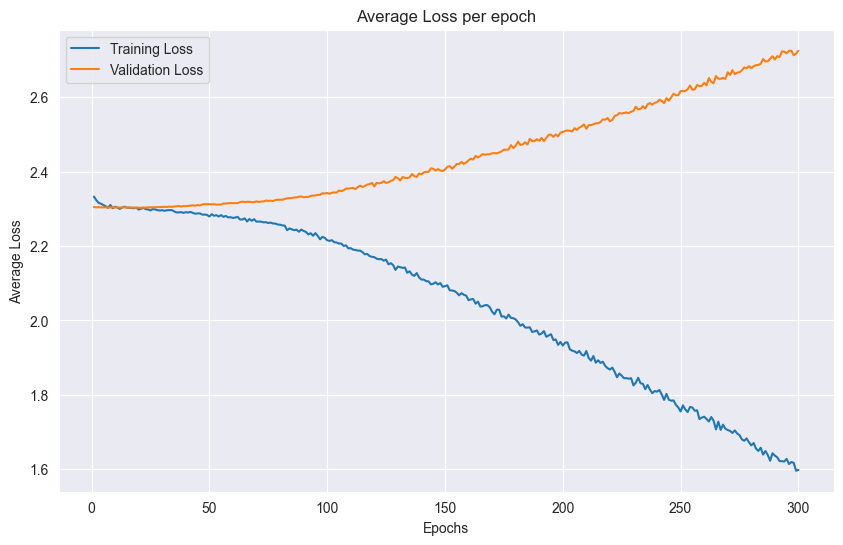

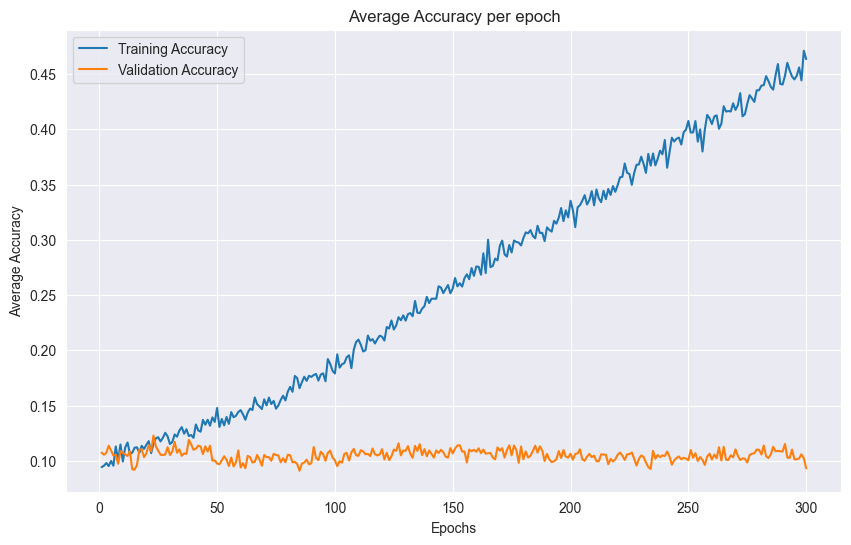

Overall Accuracy: 0.114


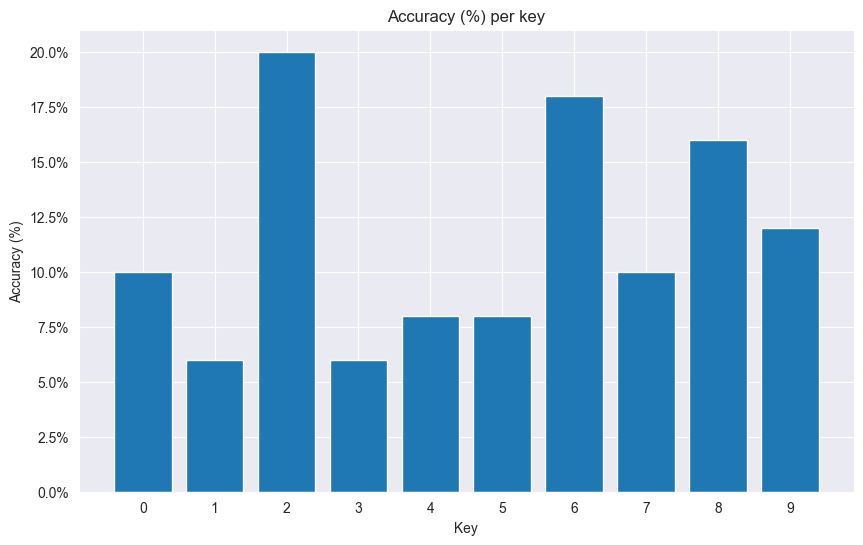

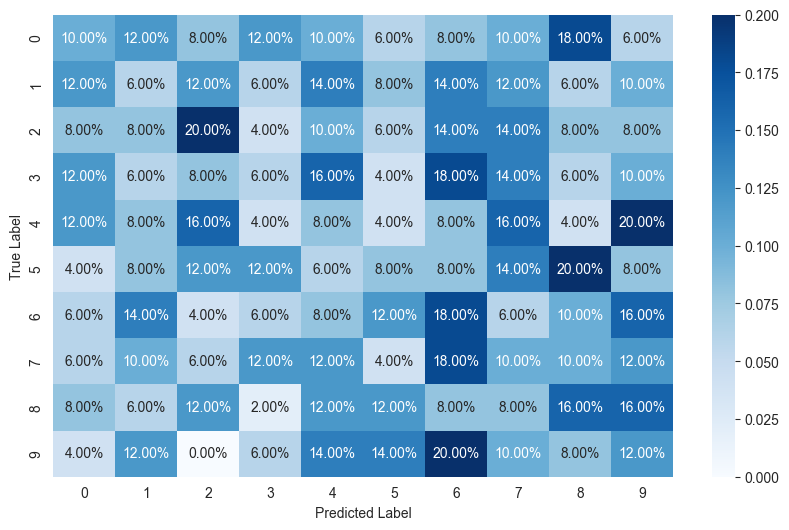

Accuracy for each key: 0: 10.0% 1: 6.0% 2: 20.0% 3: 6.0% 4: 8.0% 5: 8.0% 6: 18.0% 7: 10.0% 8: 16.0% 9: 12.0% 
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        50
           1       0.07      0.06      0.06        50
           2       0.20      0.20      0.20        50
           3       0.09      0.06      0.07        50
           4       0.07      0.08      0.08        50
           5       0.10      0.08      0.09        50
           6       0.13      0.18      0.15        50
           7       0.09      0.10      0.09        50
           8       0.15      0.16      0.16        50
           9       0.10      0.12      0.11        50

    accuracy                           0.11       500
   macro avg       0.11      0.11      0.11       500
weighted avg       0.11      0.11      0.11       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 

In [10]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 300
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()